In [118]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, Add, Conv2DTranspose, LeakyReLU, Concatenate
from keras.callbacks import Callback, ModelCheckpoint
from keras.initializers import RandomNormal, Zeros
from keras.optimizers import Adam
from keras import backend as K
from keras import Model

from IPython.display import clear_output
from IPython.display import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import keras
import cv2
import os

In [119]:
seed = 2019
np.random.seed = seed
random.seed = seed
tf.random.set_seed(seed)
path = os.getcwd()

In [120]:
image_id_list = os.listdir("./dataset/original")

In [121]:
image_size = (256, 256)
train_path = "./dataset/"
epochs = 60
validation_size = 16

In [123]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ids, filepath, batch_size=16, image_size=(256, 256), channels=3):
        self.ids=ids
        self.filepath=filepath
        self.batch_size=batch_size
        self.image_size=image_size
        self.channels=channels
        
    def __len__(self):
        return (len(self.ids)//self.batch_size)
            
    def __getitem__(self,index):
        indexes = range(
            index*self.batch_size,
            index*self.batch_size+self.batch_size
        )
        
        ids_to_load = [self.ids[k] for k in indexes]
        X = self.__generate_x(ids_to_load)
        y = self.__generate_y(ids_to_load)
        l = []
        for i, m in enumerate(X):
            l.append(m.reshape(256, 256, 3))
        X = np.array(l)
        l = []
        for i, m in enumerate(y):
            l.append(m.reshape(256, 256, 3))
        y = np.array(l)
        return X, y
            
    def __generate_x(self,id_names):
        X = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], self.channels))
        for i,id_n in enumerate(id_names):
            img = cv2.imread(self.filepath + 'drawing/' + id_n)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            img = cv2.resize(img,(self.image_size[0], self.image_size[1]))
            X[i,:,:,:] = img.reshape(self.image_size[0], self.image_size[1], self.channels)
        return X
        
    def __generate_y(self,id_names):
        y = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], self.channels))
        for i,id_n in enumerate(id_names):
            img = cv2.imread(self.filepath + 'original/' + id_n)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            img = cv2.resize(img, (self.image_size[0], self.image_size[1]))
            y[i,:,:,:] = img.reshape(self.image_size[0], self.image_size[1], self.channels)
        return y

In [124]:
train_gen = DataGenerator(
    image_id_list[:int(len(image_id_list)*0.8)],
    train_path,
    batch_size=2,
    image_size=image_size,
    channels=3
)

val_gen = DataGenerator(
    image_id_list[int(len(image_id_list)*0.8):],
    train_path,
    batch_size=2,
    image_size=image_size,
    channels=3
)

In [125]:
X, y = val_gen.__getitem__(1)
val_gen.__len__()

26

In [126]:
len(image_id_list)

256

In [127]:
X.shape

(2, 256, 256, 3)

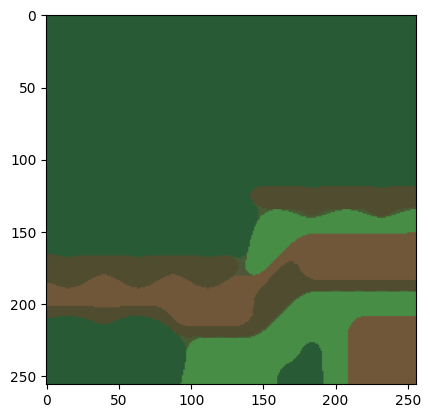

In [128]:
plt.imshow(X[0])
plt.show()

In [129]:
debug = False
#image_source_dir = './dataset/facades/'
direction = 'b2a'
input_channel = 3  # input image channels
output_channel = 3  # output image channels
lr = 0.0002
epoch = 1
crop_from = 286
#image_size = (640,480)
batch_size = 16
combined_filepath = './weights/best_weights.h5'
generator_filepath = './weights/generator.h5'
seed = 9584
imagenet_mean = np.array([0.5, 0.5, 0.5])
imagenet_std = np.array([0.5, 0.5, 0.5])

In [130]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2]).value
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1]).value
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [131]:
def residual_block(feature, dropout=False):
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return Add()([feature, x])

In [132]:
def conv_block(feature, out_channel, downsample=True, dropout=False):
    if downsample:
        x = Conv2D(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    else:
        x = Conv2DTranspose(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    return x


In [133]:
def get_generator(n_block=3):
    input = Input(shape=(image_size[0], image_size[1], input_channel))
    x = Conv2D(64, kernel_size=7, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for i in range(n_block):
        x = residual_block(x)
    # upsample
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # upsample
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out
    x = Conv2D(output_channel, kernel_size=7, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    generator = Model(inputs=input, outputs=x)
    return generator

In [134]:
def get_generator_unet(n_block=3):
    input = Input(shape=(image_size[0], image_size[1], input_channel))
    # encoder
    e0 = Conv2D(
        64,
        kernel_size=4,
        padding='same',
        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),
        bias_initializer=Zeros()
    )(input)  # use reflection padding instead

    e0 = BatchNormalization()(e0)
    e0 = Activation('relu')(e0)
    e1 = conv_block(e0, 128, downsample=True, dropout=False)  # 1/2
    e2 = conv_block(e1, 256, downsample=True, dropout=False)  # 1/4
    e3 = conv_block(e2, 512, downsample=True, dropout=False)  # 1/8
    e4 = conv_block(e3, 512, downsample=True, dropout=False)  # 1/16
    e5 = conv_block(e4, 512, downsample=True, dropout=False)  # 1/32
    e6 = conv_block(e5, 512, downsample=True, dropout=False)  # 1/64
    e7 = conv_block(e6, 512, downsample=True, dropout=False)  # 1/128
    # decoder
    d0 = conv_block(e7, 512, downsample=False, dropout=True)  # 1/64
    d1 = Concatenate(axis=-1)([d0, e6])
    d1 = conv_block(d1, 512, downsample=False, dropout=True)
    d2 = Concatenate(axis=-1)([d1, e5])
    d2 = conv_block(d2, 512, downsample=False, dropout=True)  # 1/16
    d3 = Concatenate(axis=-1)([d2, e4])
    d3 = conv_block(d3, 512, downsample=False, dropout=True)  # 1/8
    d4 = Concatenate(axis=-1)([d3, e3])
    d4 = conv_block(d4, 256, downsample=False, dropout=True)  # 1/4
    d5 = Concatenate(axis=-1)([d4, e2])
    d5 = conv_block(d5, 128, downsample=False, dropout=True)  # 1/2
    d6 = Concatenate(axis=-1)([d5, e1])
    d6 = conv_block(d6, 64, downsample=False, dropout=True)  # 1
    # out
    x = Conv2D(
        output_channel,
        kernel_size=3,
        padding='same',
        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),
        bias_initializer=Zeros()
    )(d6)  # use reflection padding instead
    
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    generator = Model(inputs=input, outputs=x)
    return generator

In [135]:
def get_generator_training_model(generator, discriminator):
    imgA = Input(shape=(image_size[0], image_size[1], input_channel))
    imgB = Input(shape=(image_size[0], image_size[1], input_channel))
    fakeB = generator(imgA)
    # discriminator.trainable=False
    realA_fakeB = Concatenate()([imgA, fakeB])
    pred_fake = discriminator(realA_fakeB)
    generator_training_model = Model(inputs=[imgA, imgB], outputs=[pred_fake, fakeB])
    return generator_training_model

In [136]:
def get_discriminator(n_layers=4, use_sigmoid=True):
    input = Input(shape=(image_size[0], image_size[1], input_channel + output_channel))
    x = Conv2D(
        64,
        kernel_size=4,
        padding='same',
        strides=2,
        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),
        bias_initializer=Zeros()
    )(input)

    x = LeakyReLU(alpha=0.2)(x)
    for i in range(1, n_layers):
        x = Conv2D(64 * 2 ** i, kernel_size=4, padding='same', strides=2, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(64 * 2 ** n_layers, kernel_size=4, padding='same', strides=1, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=4, padding='same', strides=1, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)

    if use_sigmoid:
        x = Activation('sigmoid')(x)
    discriminator = Model(inputs=input, outputs=x)
    return discriminator

In [137]:
train_step_per_epoch = int(len(image_id_list)*0.8) / batch_size + 1
test_step_per_epoch = int(len(image_id_list)*0.2) / batch_size + 1
train_image_generator =  DataGenerator(
    image_id_list[:int(len(image_id_list)*0.8)],
    train_path,
    batch_size=16,
    image_size=image_size,
    channels=3
)

test_image_generator = DataGenerator(
    image_id_list[int(len(image_id_list)*0.8):],
    train_path,
    batch_size=16,
    image_size=image_size,
    channels=3
)

In [138]:
opt1 = Adam(learning_rate=lr)
opt2 = Adam(learning_rate=lr)
discriminator = get_discriminator()
print(discriminator.summary())
generator = get_generator_unet()
generator.compile(optimizer=opt2, loss='mae', metrics=['mean_absolute_percentage_error', "mean_absolute_percentage_error"])
print(generator.summary())
generator_train = get_generator_training_model(generator, discriminator)
print(generator_train.summary())
if os.path.exists(combined_filepath):
    generator_train.load_weights(combined_filepath, by_name=True)
    generator.load_weights(generator_filepath, by_name=True)
    print('weights loaded!')
discriminator.compile(optimizer=opt1, loss='mse', metrics=['acc'], loss_weights=None)
generator_train.compile(optimizer=opt2, loss=['mse', 'mae'],
                        metrics=['mean_absolute_percentage_error', "acc"],
                        loss_weights=[1, 10])
real = np.ones((batch_size, 16, 16, 1))
fake = np.zeros((batch_size, 16, 16, 1))
best_loss = 1000

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 256, 256, 6)]     0         
                                                                 
 conv2d_75 (Conv2D)          (None, 128, 128, 64)      6208      
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_76 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_100 (B  (None, 64, 64, 128)       512       
 atchNormalization)                                              
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                          

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_81 (Conv2D)          (None, 256, 256, 64)         3136      ['input_22[0][0]']            
                                                                                                  
 batch_normalization_104 (B  (None, 256, 256, 64)         256       ['conv2d_81[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_86 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_1

In [139]:
for i in range(epochs):
    train_step = 0
    for imgA, imgB in train_image_generator:
        train_step += 1
        if train_step > train_step_per_epoch:
            test_step = 0
            total_loss = 0
            total_mape = 0
            for imgA, imgB in test_image_generator:
                test_step += 1
                if test_step > test_step_per_epoch:
                    break
                gloss, mape = generator.test_on_batch(imgA, imgB)
                total_loss += gloss
                total_mape += mape

            if total_loss / (test_step - 1) < best_loss:
                print('test loss improved from {} to {}'.format(best_loss, total_loss / (test_step - 1)))
                generator_train.save_weights(combined_filepath, overwrite=True)
                generator.save_weights(generator_filepath, overwrite=True)
                best_loss = total_loss / (test_step - 1)
            break
        discriminator.trainable = True
        imgA
        fakeB = generator.predict(imgA.reshape(2, *image_size, 3))
        loss_fake, fake_acc = discriminator.train_on_batch(np.concatenate((imgA, fakeB), axis=-1), fake)
        loss_real, real_acc = discriminator.train_on_batch(np.concatenate((imgA, imgB), axis=-1), real)
        if train_step % 20 == 0:
            print('epoch:{} train step:{}, loss d_fake:{:.2}, loss d_real:{:.2}, fake_acc:{:.2}, real_acc:{:.2}'.format(
                i + 1,
                train_step,
                loss_fake,
                loss_real,
                fake_acc,
                real_acc
            ))

        discriminator.trainable = False
        loss = generator_train.train_on_batch([imgA, imgB], [real, imgB])
        if train_step % 20 == 0:
            print('epoch:{} train step:{} loss fool:{:.2} loss g:{:.2}'.format(
                i + 1,
                train_step,
                loss[1],
                loss[0] - loss[1]
            ))

ValueError: cannot reshape array of size 3145728 into shape (2,256,256,3)

(2, 256, 256, 3)


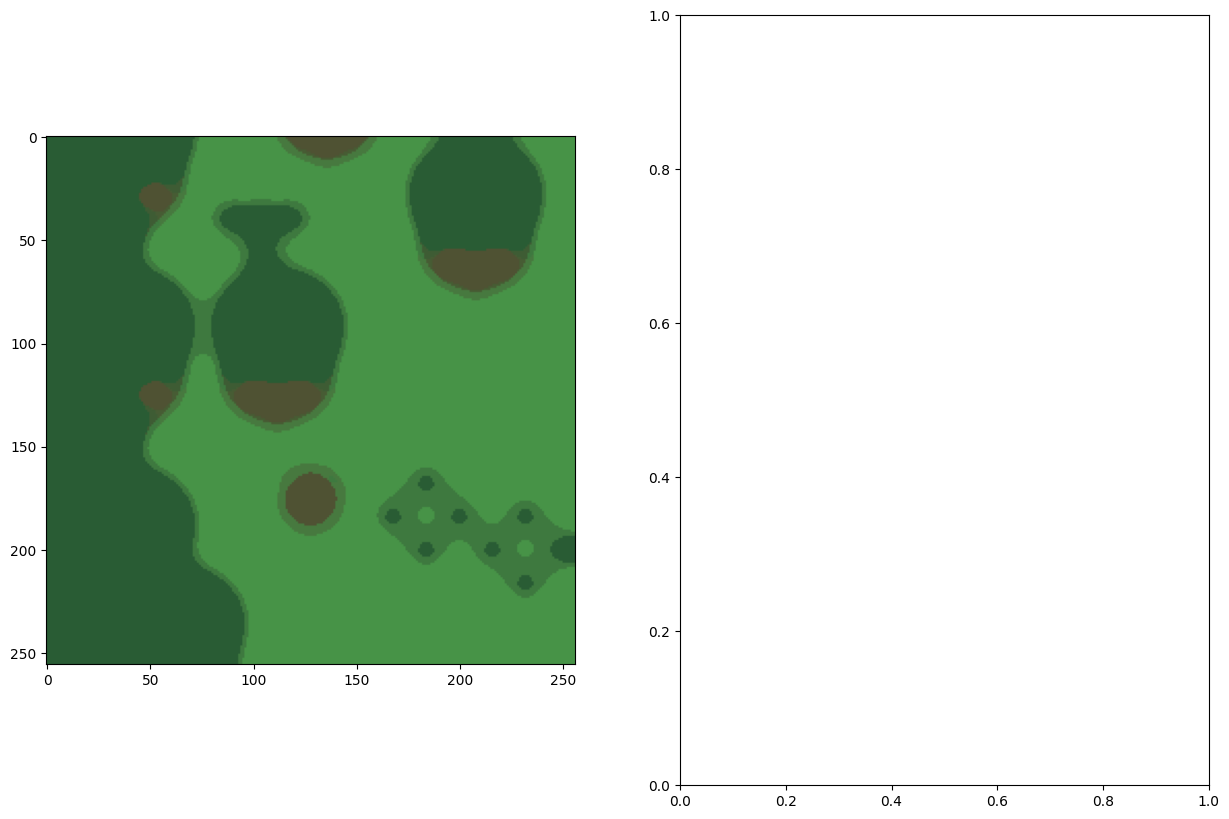

In [144]:
X,y = val_gen.__getitem__(0)
print(X.shape)
f, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(X[0])
axes[0].imshow(X[1])

In [ ]:
y_pred = generator.predict(X)

2024-02-06 05:40:41.418302: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-06 05:40:41.423285: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 16ms/step


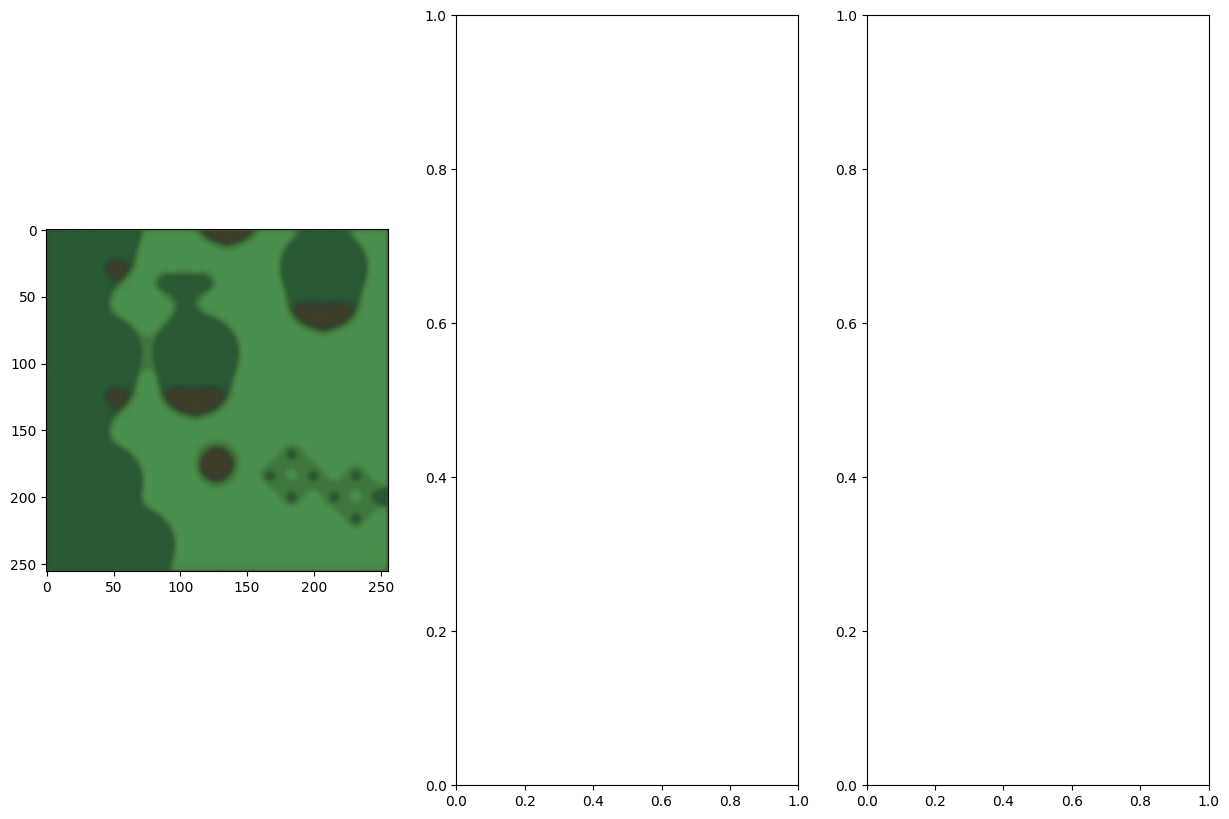

In [ ]:
y_pred = generator.predict(X)

f, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow(y[1])
axes[0].imshow(X[1])
axes[0].imshow(y_pred[1])